In [1]:
import os
import pandas as pd
import numpy as np

from sklearn.metrics import log_loss, roc_auc_score, roc_curve, make_scorer, brier_score_loss
from sklearn.model_selection import cross_validate, train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import RFE
from sklearn.linear_model import LogisticRegression
from sklearn.calibration import calibration_curve, CalibratedClassifierCV
from sklearn.inspection import permutation_importance

from lightgbm import LGBMClassifier

from skopt import BayesSearchCV
from skopt.space import Real, Integer

from joblib import dump, load
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.feature_selection import f_regression

import warnings
warnings.filterwarnings('ignore')

In [2]:
def mcfadden_r2(y, y_pred):
    ll = log_loss(y, y_pred)
    ll_null = log_loss(y, np.full(len(y), y.mean()))
    return 1 - (ll/ll_null)
pseudo_r2_scorer = make_scorer(mcfadden_r2, needs_proba=True, greater_is_better=True)
scoring = {'roc_aug': 'roc_auc', 'mcfaddens_r2': pseudo_r2_scorer}

In [3]:
cwd = os.getcwd()
df = pd.read_parquet(os.path.join(cwd, 'data', 'shots.parquet'))

In [4]:
df.drop(['match_id', 'statsbomb_id', 'statsbomb_team_id', 'player_id_statsbomb', 'competition_gender', 'team_name',
         'player_id', 'firstName', 'middleName', 'lastName', 'Name', 'dataset', 'wyscout_id', 'wyscout_team_id', 'team_id',
         'player_id_wyscout','competition_name','minute','shot_zone','match_week','pass_end_y',
         'goalkeeper_x', 'goalkeeper_y', 'carry_length', 'shot_one_on_one', 'shot_open_goal','under_pressure', 'area_shot', 
         'area_goal', 'n_angle', 'smart_pass','pass_end_x'], axis=1, inplace=True)
mask_penalty = (df.shot_type_name=='penalty')
df_penalty = df[mask_penalty].copy()
df_penalty.drop(['x','y','visible_angle','middle_angle','distance_to_goal','distance_visible_angle','log_distance_to_goal',
                 'assist_type', 'pass_switch', 'pass_cross', 'pass_cut_back','counter_attack', 'pass_height_name',
                 'pass_technique_name', 'shot_zone_number','shot_zone_player_number','fast_break', 'strong_foot',
                 'body_part_name','shot_type_name'], axis=1, inplace=True)
df_non_penalty = df[~mask_penalty].copy()

In [5]:
def split(X):
    mask = X.assist_type == 'pass'
    X_pass = X[mask].drop('assist_type', axis=1).copy()
    X_other = X[~mask].dropna(axis=1, how='all').copy()
    return X_pass, X_other

In [6]:
df_np_pass,  df_np_other = split(df_non_penalty)

In [7]:
df_np_pass = pd.get_dummies(df_np_pass, columns=['competition_type','competition_part','H_A_column','match_moment',
                                                 'shot_type_name', 'body_part_name','pass_technique_name','pass_height_name'])
df_np_other = pd.get_dummies(df_np_other, columns=['competition_type','competition_part','H_A_column','match_moment',
                                                   'assist_type','shot_type_name', 'body_part_name'])
df_p = pd.get_dummies(df_penalty, columns=['competition_type','competition_part','H_A_column','match_moment'])
y_np_pass = df_np_pass['goal']
x_np_pass = df_np_pass.drop(['goal'], axis=1)
x_npp_train, x_npp_test, y_npp_train, y_npp_test = train_test_split(x_np_pass, y_np_pass, test_size=0.2, random_state=42,
                                                                    stratify=y_np_pass)
y_np_other = df_np_other['goal']
x_np_other = df_np_other.drop(['goal'], axis=1)
x_npo_train, x_npo_test, y_npo_train, y_npo_test = train_test_split(x_np_other, y_np_other, test_size=0.2, random_state=42,
                                                                   stratify=y_np_other)
y_p = df_p['goal']
x_p = df_p.drop(['goal'], axis=1)
x_p_train, x_p_test, y_p_train, y_p_test = train_test_split(x_p, y_p, test_size=0.2, random_state=42, stratify=y_p)

In [8]:
print('Shots pass train', len(y_npp_train), ';Number goals', y_npp_train.sum(),
      ';Goals %: ', round(y_npp_train.mean()*100, 1))
print('Shots pass test', len(y_npp_test), ';Number goals', y_npp_test.sum(),
      ';Goals %: ', round(y_npp_test.mean()*100, 1))

Shots pass train 35198 ;Number goals 3860 ;Goals %:  11.0
Shots pass test 8800 ;Number goals 965 ;Goals %:  11.0


In [9]:
print('Shots other train', len(y_npo_train), ';Number goals', y_npo_train.sum(),
      ';Goals %: ', round(y_npo_train.mean()*100, 1))
print('Shots other test', len(y_npo_test), ';Number goals', y_npo_test.sum(),
      ';Goals %: ', round(y_npo_test.mean()*100, 1))

Shots other train 16406 ;Number goals 1618 ;Goals %:  9.9
Shots other test 4102 ;Number goals 404 ;Goals %:  9.8


In [10]:
print('Shots penalty train', len(y_p_train), ';Number goals', y_p_train.sum(),
      ';Goals %: ', round(y_p_train.mean()*100, 1))
print('Shots penalty test', len(y_p_test), ';Number goals', y_p_test.sum(),
      ';Goals %: ', round(y_p_test.mean()*100, 1))

Shots penalty train 656 ;Number goals 486 ;Goals %:  74.1
Shots penalty test 165 ;Number goals 122 ;Goals %:  73.9


In [11]:
logreg = LogisticRegression(solver='sag', n_jobs=-1, max_iter=100, random_state=42)
rfe_npp = RFE(logreg, 24)
rfe_npp = rfe_npp.fit(x_npp_train, y_npp_train)

x_npp_train = x_npp_train.loc[:, rfe_npp.support_]
x_npp_test = x_npp_test.loc[:, rfe_npp.support_]

In [12]:
sc = StandardScaler()
x_npp_train_sc = sc.fit_transform(x_npp_train)
x_npp_test_sc = sc.fit_transform(x_npp_test)

In [13]:
lr = LogisticRegression(random_state=42, solver='sag', max_iter=100)

In [14]:
grid={"C": np.logspace(-3,3,7)}

In [15]:
logistic_regression_npp = GridSearchCV(estimator=lr, param_grid=grid, scoring='neg_log_loss', n_jobs=-1)
logistic_regression_npp.fit(x_npp_train_sc, y_npp_train)
train_y_npp_hat = logistic_regression_npp.predict_proba(x_npp_train_sc.astype(float))
y_pred_lr_npp = logistic_regression_npp.predict_proba(x_npp_test_sc.astype(float))

In [16]:
naive_train_log_loss_npp = log_loss(y_npp_train, train_y_npp_hat[:,1])
naive_train_roc_auc_npp = roc_auc_score(y_npp_train, train_y_npp_hat[:,1])
print('The log loss of our non-penalty pass model on the training set is : ' +str(round(naive_train_log_loss_npp, 4)))
print('The ROC AUC of our non-penalty pass model on the training set is : ' +str(round(naive_train_roc_auc_npp, 4)))
print("McFadden's Pseudo R-squared shots assisted by passes : "  +str(round( mcfadden_r2(y_npp_train, train_y_npp_hat), 4)))

The log loss of our non-penalty pass model on the training set is : 0.2895
The ROC AUC of our non-penalty pass model on the training set is : 0.7843
McFadden's Pseudo R-squared shots assisted by passes : 0.1629


In [17]:
rfe_npo = RFE(logreg, 24)
rfe_npo = rfe_npo.fit(x_npo_train, y_npo_train)

x_npo_train = x_npo_train.loc[:, rfe_npo.support_]
x_npo_test = x_npo_test.loc[:, rfe_npo.support_]

In [18]:
sc = StandardScaler()
x_npo_train_sc = sc.fit_transform(x_npo_train)
x_npo_test_sc = sc.fit_transform(x_npo_test)

In [19]:
logistic_regression_npo = GridSearchCV(estimator=lr, param_grid=grid, scoring='neg_log_loss', n_jobs=-1)
logistic_regression_npo.fit(x_npo_train_sc, y_npo_train)
train_y_npo_hat = logistic_regression_npo.predict_proba(x_npo_train_sc.astype(float))
y_pred_lr_npo = logistic_regression_npo.predict_proba(x_npo_test_sc.astype(float))

In [20]:
naive_train_log_loss_npo = log_loss(y_npo_train, train_y_npo_hat[:,1])
naive_train_roc_auc_npo = roc_auc_score(y_npo_train, train_y_npo_hat[:,1])
print('The log loss of our non-penalty other model on the training set is : ' +str(round(naive_train_log_loss_npo, 4)))
print('The ROC AUC of our non-penalty other model on the training set is : ' +str(round(naive_train_roc_auc_npo, 4)))
print("McFadden's Pseudo R-squared shots assisted by passes : "  +str(round( mcfadden_r2(y_npp_train, train_y_npp_hat), 4)))

The log loss of our non-penalty other model on the training set is : 0.2595
The ROC AUC of our non-penalty other model on the training set is : 0.8061
McFadden's Pseudo R-squared shots assisted by passes : 0.1629


In [21]:
rfe_p = RFE(logreg, 10)
rfe_p = rfe_p.fit(x_p_train, y_p_train)

x_p_train = x_p_train.loc[:, rfe_p.support_]
x_p_test = x_p_test.loc[:, rfe_p.support_]

In [22]:
sc = StandardScaler()
x_p_train_sc = sc.fit_transform(x_p_train)
x_p_test_sc = sc.fit_transform(x_p_test)

In [23]:
logistic_regression_p = GridSearchCV(estimator=lr, param_grid=grid, scoring='neg_log_loss', n_jobs=-1)
logistic_regression_p.fit(x_p_train_sc, y_p_train)
train_y_p_hat = logistic_regression_p.predict_proba(x_p_train_sc.astype(float))
y_pred_lr_p = logistic_regression_p.predict_proba(x_p_test_sc.astype(float))

In [24]:
naive_train_log_loss_p = log_loss(y_p_train, train_y_p_hat[:,1])
naive_train_roc_auc_p = roc_auc_score(y_p_train, train_y_p_hat[:,1])
print('The log loss of our penalty model on the training set is : ' +str(round(naive_train_log_loss_p, 4)))
print('The ROC AUC of our penalty model on the training set is : ' +str(round(naive_train_roc_auc_p, 4)))
print("McFadden's Pseudo R-squared penaltys : "  +str(round( mcfadden_r2(y_p_train, train_y_p_hat), 4)))

The log loss of our penalty model on the training set is : 0.5708
The ROC AUC of our penalty model on the training set is : 0.5789
McFadden's Pseudo R-squared penaltys : 0.0025


In [25]:
logreg = LogisticRegression(multi_class='multinomial', solver='saga')
rfe_npp2 = RFE(logreg, 20)
rfe_npp2 = rfe_npp2.fit(x_npp_train, y_npp_train)

x_npp_train2 = x_npp_train.loc[:, rfe_npp2.support_]
x_npp_test2 = x_npp_test.loc[:, rfe_npp2.support_]

In [26]:
sc = StandardScaler()
x_npp_train_sc2 = sc.fit_transform(x_npp_train2)
x_npp_test_sc2 = sc.fit_transform(x_npp_test2)

In [27]:
logistic_regression_npp = GridSearchCV(estimator=lr, param_grid=grid, scoring='neg_log_loss', n_jobs=-1)
logistic_regression_npp.fit(x_npp_train_sc2, y_npp_train)
train_y_npp_hat = logistic_regression_npp.predict_proba(x_npp_train_sc2.astype(float))
y_pred_lr_npp = logistic_regression_npp.predict_proba(x_npp_test_sc2.astype(float))

In [28]:
naive_train_log_loss_npp = log_loss(y_npp_train, train_y_npp_hat[:,1])
naive_train_roc_auc_npp = roc_auc_score(y_npp_train, train_y_npp_hat[:,1])
print('The log loss of our non-penalty pass model on the training set is : ' +str(round(naive_train_log_loss_npp, 4)))
print('The ROC AUC of our non-penalty pass model on the training set is : ' +str(round(naive_train_roc_auc_npp, 4)))
print("McFadden's Pseudo R-squared shots assisted by passes : "  +str(round( mcfadden_r2(y_npp_train, train_y_npp_hat), 4)))

The log loss of our non-penalty pass model on the training set is : 0.2897
The ROC AUC of our non-penalty pass model on the training set is : 0.7841
McFadden's Pseudo R-squared shots assisted by passes : 0.1621


In [29]:
freg=f_regression(x_npp_train_sc2, y_npp_train)
p=freg[1]
print(p.round(3))

[0.    0.017 0.067 0.    0.    0.002 0.    0.    0.005 0.006 0.009 0.
 0.54  0.088 0.001 0.256 0.383 0.    0.    0.037]


In [30]:
rfe_npo2 = RFE(logreg, 20)
rfe_npo2 = rfe_npo2.fit(x_npo_train, y_npo_train)

x_npo_train2 = x_npo_train.loc[:, rfe_npo2.support_]
x_npo_test2 = x_npo_test.loc[:, rfe_npo2.support_]

In [31]:
sc = StandardScaler()
x_npo_train_sc2 = sc.fit_transform(x_npo_train2)
x_npo_test_sc2 = sc.fit_transform(x_npo_test2)

In [32]:
logistic_regression_npo = GridSearchCV(estimator=lr, param_grid=grid, scoring='neg_log_loss', n_jobs=-1)
logistic_regression_npo.fit(x_npo_train_sc2, y_npo_train)
train_y_npo_hat = logistic_regression_npo.predict_proba(x_npo_train_sc2.astype(float))
y_pred_lr_npo = logistic_regression_npo.predict_proba(x_npo_test_sc2.astype(float))

In [33]:
naive_train_log_loss_npo = log_loss(y_npo_train, train_y_npo_hat[:,1])
naive_train_roc_auc_npo = roc_auc_score(y_npo_train, train_y_npo_hat[:,1])
print('The log loss of our non-penalty other model on the training set is : ' +str(round(naive_train_log_loss_npo, 4)))
print('The ROC AUC of our non-penalty other model on the training set is : ' +str(round(naive_train_roc_auc_npo, 4)))
print("McFadden's Pseudo R-squared shots assisted by passes : "  +str(round( mcfadden_r2(y_npp_train, train_y_npp_hat), 4)))

The log loss of our non-penalty other model on the training set is : 0.2597
The ROC AUC of our non-penalty other model on the training set is : 0.8062
McFadden's Pseudo R-squared shots assisted by passes : 0.1621


In [34]:
rfe_p2 = RFE(logreg, 8)
rfe_p2 = rfe_p2.fit(x_p_train, y_p_train)

x_p_train2 = x_p_train.loc[:, rfe_p2.support_]
x_p_test2 = x_p_test.loc[:, rfe_p2.support_]

In [35]:
sc = StandardScaler()
x_p_train_sc2 = sc.fit_transform(x_p_train2)
x_p_test_sc2 = sc.fit_transform(x_p_test2)

In [36]:
logistic_regression_p = GridSearchCV(estimator=lr, param_grid=grid, scoring='neg_log_loss', n_jobs=-1)
logistic_regression_p.fit(x_p_train_sc2, y_p_train)
train_y_p_hat = logistic_regression_p.predict_proba(x_p_train_sc2.astype(float))
y_pred_lr_p = logistic_regression_p.predict_proba(x_p_test_sc2.astype(float))

In [37]:
naive_train_log_loss_p = log_loss(y_p_train, train_y_p_hat[:,1])
naive_train_roc_auc_p = roc_auc_score(y_p_train, train_y_p_hat[:,1])
print('The log loss of our penalty model on the training set is : ' +str(round(naive_train_log_loss_p, 4)))
print('The ROC AUC of our penalty model on the training set is : ' +str(round(naive_train_roc_auc_p, 4)))
print("McFadden's Pseudo R-squared penaltys : "  +str(round( mcfadden_r2(y_p_train, train_y_p_hat), 4)))

The log loss of our penalty model on the training set is : 0.5709
The ROC AUC of our penalty model on the training set is : 0.5776
McFadden's Pseudo R-squared penaltys : 0.0023


In [38]:
logreg = LogisticRegression(multi_class='multinomial', solver='saga')
rfe_npp3 = RFE(logreg, 10)
rfe_npp3 = rfe_npp3.fit(x_npp_train, y_npp_train)

x_npp_train3 = x_npp_train.loc[:, rfe_npp3.support_]
x_npp_test3 = x_npp_test.loc[:, rfe_npp3.support_]

In [39]:
sc = StandardScaler()
x_npp_train_sc3 = sc.fit_transform(x_npp_train3)
x_npp_test_sc3 = sc.fit_transform(x_npp_test3)

In [40]:
logistic_regression_npp = GridSearchCV(estimator=lr, param_grid=grid, scoring='neg_log_loss', n_jobs=-1)
logistic_regression_npp.fit(x_npp_train_sc3, y_npp_train)
train_y_npp_hat = logistic_regression_npp.predict_proba(x_npp_train_sc3.astype(float))
y_pred_lr_npp = logistic_regression_npp.predict_proba(x_npp_test_sc3.astype(float))

In [41]:
naive_train_log_loss_npp = log_loss(y_npp_train, train_y_npp_hat[:,1])
naive_train_roc_auc_npp = roc_auc_score(y_npp_train, train_y_npp_hat[:,1])
print('The log loss of our non-penalty pass model on the training set is : ' +str(round(naive_train_log_loss_npp, 4)))
print('The ROC AUC of our non-penalty pass model on the training set is : ' +str(round(naive_train_roc_auc_npp, 4)))
print("McFadden's Pseudo R-squared shots assisted by passes : "  +str(round( mcfadden_r2(y_npp_train, train_y_npp_hat), 4)))

The log loss of our non-penalty pass model on the training set is : 0.2903
The ROC AUC of our non-penalty pass model on the training set is : 0.7829
McFadden's Pseudo R-squared shots assisted by passes : 0.1604


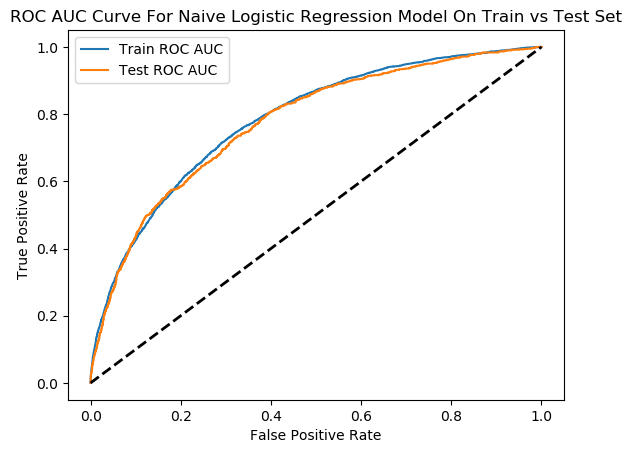

In [42]:
plt.style.use('default')
train_npp_fpr, train_npp_tpr, train_npp_thresholds = roc_curve(y_true=y_npp_train, y_score=train_y_npp_hat[:,1])
test_npp_fpr, test_npp_tpr, test_npp_thresholds = roc_curve(y_true=y_npp_test, y_score=y_pred_lr_npp[:,1])
plt.plot(train_npp_fpr, train_npp_tpr, label = 'Train ROC AUC')
plt.plot(test_npp_fpr, test_npp_tpr, label = 'Test ROC AUC')
plt.plot([0, 1], [0, 1], color = 'black', linewidth = 2, linestyle = '--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
plt.title('ROC AUC Curve For Naive Logistic Regression Model On Train vs Test Set')
plt.show()

In [43]:
freg=f_regression(x_npp_train_sc3, y_npp_train)
p=freg[1]
print(p.round(3))

[0.    0.067 0.    0.    0.    0.006 0.009 0.088 0.    0.037]


In [44]:
rfe_npo3 = RFE(logreg, 14)
rfe_npo3 = rfe_npo3.fit(x_npo_train, y_npo_train)

x_npo_train3 = x_npo_train.loc[:, rfe_npo3.support_]
x_npo_test3 = x_npo_test.loc[:, rfe_npo3.support_]

In [45]:
sc = StandardScaler()
x_npo_train_sc3 = sc.fit_transform(x_npo_train3)
x_npo_test_sc3 = sc.fit_transform(x_npo_test3)

In [46]:
logistic_regression_npo = GridSearchCV(estimator=lr, param_grid=grid, scoring='neg_log_loss', n_jobs=-1)
logistic_regression_npo.fit(x_npo_train_sc3, y_npo_train)
train_y_npo_hat = logistic_regression_npo.predict_proba(x_npo_train_sc3.astype(float))
y_pred_lr_npo = logistic_regression_npo.predict_proba(x_npo_test_sc3.astype(float))

In [47]:
naive_train_log_loss_npo = log_loss(y_npo_train, train_y_npo_hat[:,1])
naive_train_roc_auc_npo = roc_auc_score(y_npo_train, train_y_npo_hat[:,1])
print('The log loss of our non-penalty other model on the training set is : ' +str(round(naive_train_log_loss_npo, 4)))
print('The ROC AUC of our non-penalty other model on the training set is : ' +str(round(naive_train_roc_auc_npo, 4)))
print("McFadden's Pseudo R-squared shots assisted by passes : "  +str(round( mcfadden_r2(y_npp_train, train_y_npp_hat), 4)))

The log loss of our non-penalty other model on the training set is : 0.2602
The ROC AUC of our non-penalty other model on the training set is : 0.8049
McFadden's Pseudo R-squared shots assisted by passes : 0.1604


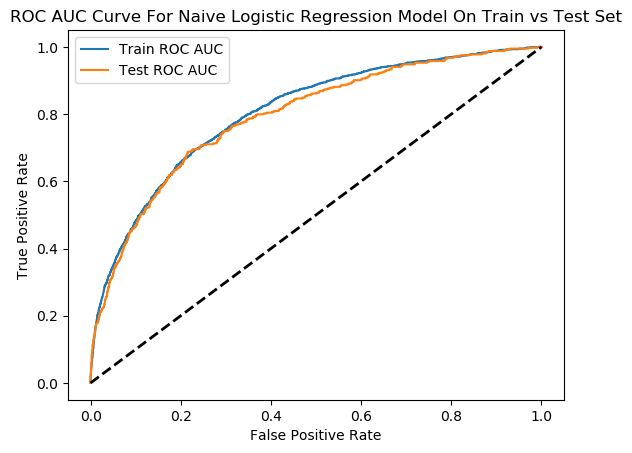

In [48]:
test_y_npo_hat = logistic_regression_npo.predict(x_npo_test3.astype(float))
train_npo_fpr, train_npo_tpr, train_npo_thresholds = roc_curve(y_true=y_npo_train, y_score=train_y_npo_hat[:,1])
test_npo_fpr, test_npo_tpr, test_npo_thresholds = roc_curve(y_true=y_npo_test, y_score=y_pred_lr_npo[:,1])
plt.plot(train_npo_fpr, train_npo_tpr, label = 'Train ROC AUC')
plt.plot(test_npo_fpr, test_npo_tpr, label = 'Test ROC AUC')
plt.plot([0, 1], [0, 1], color = 'black', linewidth = 2, linestyle = '--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
plt.title('ROC AUC Curve For Naive Logistic Regression Model On Train vs Test Set')
plt.show()

In [49]:
freg=f_regression(x_npo_train_sc3, y_npo_train)
p=freg[1]
print(p.round(3))

[0.    0.073 0.    0.    0.    0.    0.029 0.    0.    0.018 0.    0.
 0.891 0.   ]


In [50]:
rfe_p3 = RFE(logreg, 1)
rfe_p3 = rfe_p3.fit(x_p_train, y_p_train)

x_p_train3 = x_p_train.loc[:, rfe_p3.support_]
x_p_test3 = x_p_test.loc[:, rfe_p3.support_]

In [51]:
sc = StandardScaler()
x_p_train_sc3 = sc.fit_transform(x_p_train3)
x_p_test_sc3 = sc.fit_transform(x_p_test3)

In [52]:
logistic_regression_p = GridSearchCV(estimator=lr, param_grid=grid, scoring='neg_log_loss', n_jobs=-1)
logistic_regression_p.fit(x_p_train_sc3, y_p_train)
train_y_p_hat = logistic_regression_p.predict_proba(x_p_train_sc3.astype(float))
y_pred_lr_p = logistic_regression_p.predict_proba(x_p_test_sc3.astype(float))

In [53]:
naive_train_log_loss_p = log_loss(y_p_train, train_y_p_hat[:,1])
naive_train_roc_auc_p = roc_auc_score(y_p_train, train_y_p_hat[:,1])
print('The log loss of our penalty model on the training set is : ' +str(round(naive_train_log_loss_p, 4)))
print('The ROC AUC of our penalty model on the training set is : ' +str(round(naive_train_roc_auc_p, 4)))
print("McFadden's Pseudo R-squared penaltys : "  +str(round( mcfadden_r2(y_p_train, train_y_p_hat), 4)))

The log loss of our penalty model on the training set is : 0.5717
The ROC AUC of our penalty model on the training set is : 0.5063
McFadden's Pseudo R-squared penaltys : 0.0008


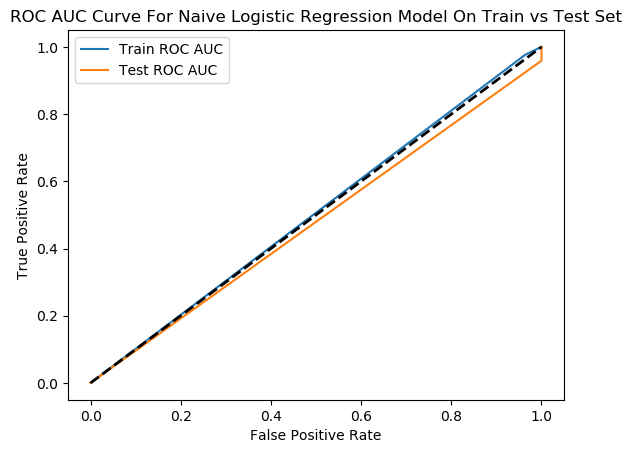

In [54]:
test_y_p_hat = logistic_regression_p.predict(x_p_test3.astype(float))
train_p_fpr, train_p_tpr, train_p_thresholds = roc_curve(y_true=y_p_train, y_score=train_y_p_hat[:,1])
test_p_fpr, test_p_tpr, test_p_thresholds = roc_curve(y_true=y_p_test, y_score=y_pred_lr_p[:,1])
plt.plot(train_p_fpr, train_p_tpr, label = 'Train ROC AUC')
plt.plot(test_p_fpr, test_p_tpr, label = 'Test ROC AUC')
plt.plot([0, 1], [0, 1], color = 'black', linewidth = 2, linestyle = '--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
plt.title('ROC AUC Curve For Naive Logistic Regression Model On Train vs Test Set')
plt.show()

In [55]:
freg=f_regression(x_p_train_sc3, y_p_train)
p=freg[1]
print(p.round(3))

[0.372]


# LightGBM

Load the data

In [56]:
df2 = pd.read_parquet(os.path.join(cwd, 'data', 'shots.parquet'))
df2.drop(['match_id', 'statsbomb_id', 'statsbomb_team_id', 'player_id_statsbomb', 'competition_gender', 'team_name',
         'player_id', 'firstName', 'middleName', 'lastName', 'Name', 'dataset', 'wyscout_id', 'wyscout_team_id', 'team_id',
         'player_id_wyscout','competition_name','minute','shot_zone','competition_gender','match_week'], axis=1, inplace=True)
mask_penalty = (df2.shot_type_name=='penalty')
df_penalty = df2[mask_penalty].copy()
df_penalty.drop(['x','y','visible_angle','middle_angle','distance_to_goal','distance_visible_angle','log_distance_to_goal',
                 'assist_type', 'pass_switch', 'pass_cross', 'pass_cut_back','counter_attack', 'pass_height_name',
                 'pass_technique_name', 'shot_zone_number','shot_zone_player_number','fast_break', 'strong_foot',
                 'body_part_name','shot_type_name','smart_pass','carry_length','pass_end_x','pass_end_y',
                 'goalkeeper_x', 'goalkeeper_y','n_angle','area_goal','area_shot','shot_one_on_one','shot_open_goal',
                'under_pressure'], axis=1, inplace=True)
df_non_penalty = df2[~mask_penalty].copy()
X_penalty = df_penalty.drop('goal', axis=1)
y_penalty = df_penalty.goal
X = df_non_penalty.drop('goal', axis=1)
y = df_non_penalty.goal

Split into train, calibration and test datasets

In [57]:
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.8, random_state=42, stratify=y)
X_penalty_train, X_penalty_test, y_penalty_train, y_penalty_test = train_test_split(X_penalty, y_penalty,
                                                                        train_size=0.8, random_state=42, stratify=y_penalty)

In [58]:
print('Shots train', len(y_train), ';Number goals', y_train.sum(),
      ';Goals %: ', round(y_train.mean()*100, 1))
print('Shots test', len(y_test), ';Number goals', y_test.sum(),
      ';Goals %: ', round(y_test.mean()*100, 1))

Shots train 51604 ;Number goals 5478 ;Goals %:  10.6
Shots test 12902 ;Number goals 1369 ;Goals %:  10.6


In [59]:
print('Penalty Shots train', len(y_penalty_train), ';Penalty Number goals', y_penalty_train.sum(),
      ';Penalty Goals %: ', round(y_penalty_train.mean()*100, 1))
print('Penalty Shots test', len(y_penalty_test), ';Penalty Number goals', y_penalty_test.sum(),
      ';Penalty Goals %: ', round(y_penalty_test.mean()*100, 1))

Penalty Shots train 656 ;Penalty Number goals 486 ;Penalty Goals %:  74.1
Penalty Shots test 165 ;Penalty Number goals 122 ;Penalty Goals %:  73.9


Load and split fake data

In [60]:
df_fake = pd.read_parquet(os.path.join(cwd, 'data', 'fake_shots.parquet'))
df_fake.drop(['competition_gender','competition_gender','match_week'], axis=1, inplace=True)
df_fake.index = ['a'+str(idx) for idx in df_fake.index]

y_fake = df_fake.goal
X_fake = df_fake.drop('goal', axis=1)

In [61]:
print('Shots fake', len(y_fake), ';Goals %: ', round(y_fake.mean()*100, 1))

Shots fake 1000 ;Goals %:  3.4


Add fake training data. I am not adding this to the test data as want this to be realistic of real data.

In [62]:
X_train = pd.concat([X_train, X_fake])
y_train = pd.concat([y_train, y_fake])

Clean data. Categories to numbers. Drop distance and angle measures as just want raw locations for my models.

In [63]:
def clean_lightgbm(df):
    df = df.copy()
    # replace categorical columns
    shot_type_cat = {'free_kick': 0, 'corner': 1, 'throw_in': 2, 'direct_set_piece': 3, 'open_play': 4}
    body_type_cat = {'Right Foot': 0, 'Left Foot': 1, 'Other': 2}
    assist_type_cat = {'pass': 0, 'recovery': 1, 'clearance': 2, 'direct': 3, 'rebound': 4}
    pass_height_cat = {'High Pass': 0, 'Ground/ Low Pass': 1}
    pass_technique_cat = {'Through Ball': 0, 'Straight': 1, 'Inswinging': 2, 'Outswinging': 3, 'other': 4}
    H_A_column_cat = {'Home Team': 0, 'Away Team': 1}
    match_moment_cat = {'0-15': 0, '15-30': 1, '30-45': 2, '45-60': 3, '60-75': 4, '75-90': 5}
    competition_type_cat = {'League': 0, 'Cup': 1}
    competition_part_cat = {'start': 0, 'middle': 1, 'final': 2, 'group': 3, 'knockout': 4}
    df.shot_type_name.replace(shot_type_cat, inplace=True)
    df.body_part_name.replace(body_type_cat, inplace=True)
    df.assist_type.replace(assist_type_cat, inplace=True)
    df.pass_height_name.replace(pass_height_cat, inplace=True)
    df.pass_technique_name.replace(pass_technique_cat, inplace=True)
    df.H_A_column.replace(H_A_column_cat, inplace=True)
    df.match_moment.replace(match_moment_cat, inplace=True)
    df.competition_type.replace(competition_type_cat, inplace=True)
    df.competition_part.replace(competition_part_cat, inplace=True)
    
    # replace boolean type columns (not really as have nans)
    for col in ['pass_switch', 'pass_cross', 'pass_cut_back', 'shot_one_on_one',
                'shot_open_goal', 'under_pressure', 'smart_pass']:
        df[col] = df[col].astype(np.float32)
    return df
    
X_train = clean_lightgbm(X_train)
X_test = clean_lightgbm(X_test)

Clean data. Categories to numbers. Drop distance and angle measures as just want raw locations for my models.

In [64]:
def clean_lightgbm_p(df):
    df = df.copy()
    # replace categorical columns
    H_A_column_cat = {'Home Team': 0, 'Away Team': 1}
    match_moment_cat = {'0-15': 0, '15-30': 1, '30-45': 2, '45-60': 3, '60-75': 4, '75-90': 5}
    competition_type_cat = {'League': 0, 'Cup': 1}
    competition_part_cat = {'start': 0, 'middle': 1, 'final': 2, 'group': 3, 'knockout': 4}
    df.H_A_column.replace(H_A_column_cat, inplace=True)
    df.match_moment.replace(match_moment_cat, inplace=True)
    df.competition_type.replace(competition_type_cat, inplace=True)
    df.competition_part.replace(competition_part_cat, inplace=True)
    return df
    
X_penalty_train = clean_lightgbm_p(X_penalty_train)
X_penalty_test = clean_lightgbm_p(X_penalty_test)

Fit the nested 5-fold cross validation using Bayesian optimisation.

In [65]:
lgbm = CalibratedClassifierCV(LGBMClassifier(random_state=42), method='isotonic', cv=3)
lgbm_param_grid = {'base_estimator__min_child_samples': Integer(0, 200),
                   'base_estimator__num_leaves': Integer(2, 500),
                   'base_estimator__reg_lambda': Real(0, 1),
                   'base_estimator__reg_alpha': Real(0, 1),
                   'base_estimator__max_depth': Integer(0, 500)}

Nested resampling using skopt. see: https://github.com/scikit-optimize/scikit-optimize/issues/725

In [66]:
searchcv = BayesSearchCV(estimator=lgbm,
                         n_iter=100,
                         search_spaces=lgbm_param_grid,
                         cv=5,
                         n_jobs=-1)
searchcv.fit(X_train, y_train)
y_pred_lgbm = searchcv.best_estimator_.predict_proba(X_test)

Permutation importance

In [67]:
perm_result = permutation_importance(searchcv.best_estimator_, X_train, y_train, n_repeats=10, random_state=42)
df_perm_importance = pd.DataFrame({'Feature':X_train.columns,
                                   'importance': perm_result.importances.mean(axis=1),
                                   'std_dev': perm_result.importances.std(axis=1)})
df_perm_importance.sort_values('importance', ascending=False, inplace=True)
df_perm_importance.reset_index(drop=True, inplace=True)
df_perm_importance

,Feature,importance,std_dev
0,visible_angle,0.005853,0.000247
1,distance_to_goal,0.005336,0.000209
2,body_part_name,0.001390,0.000188
3,goalkeeper_x,0.000924,0.000087
4,n_angle,0.000861,0.000151
5,shot_type_name,0.000823,0.000182
6,x,0.000437,0.000125
7,shot_open_goal,0.000395,0.000058
8,assist_type,0.000384,0.000129
9,pass_height_name,0.000369,0.000125


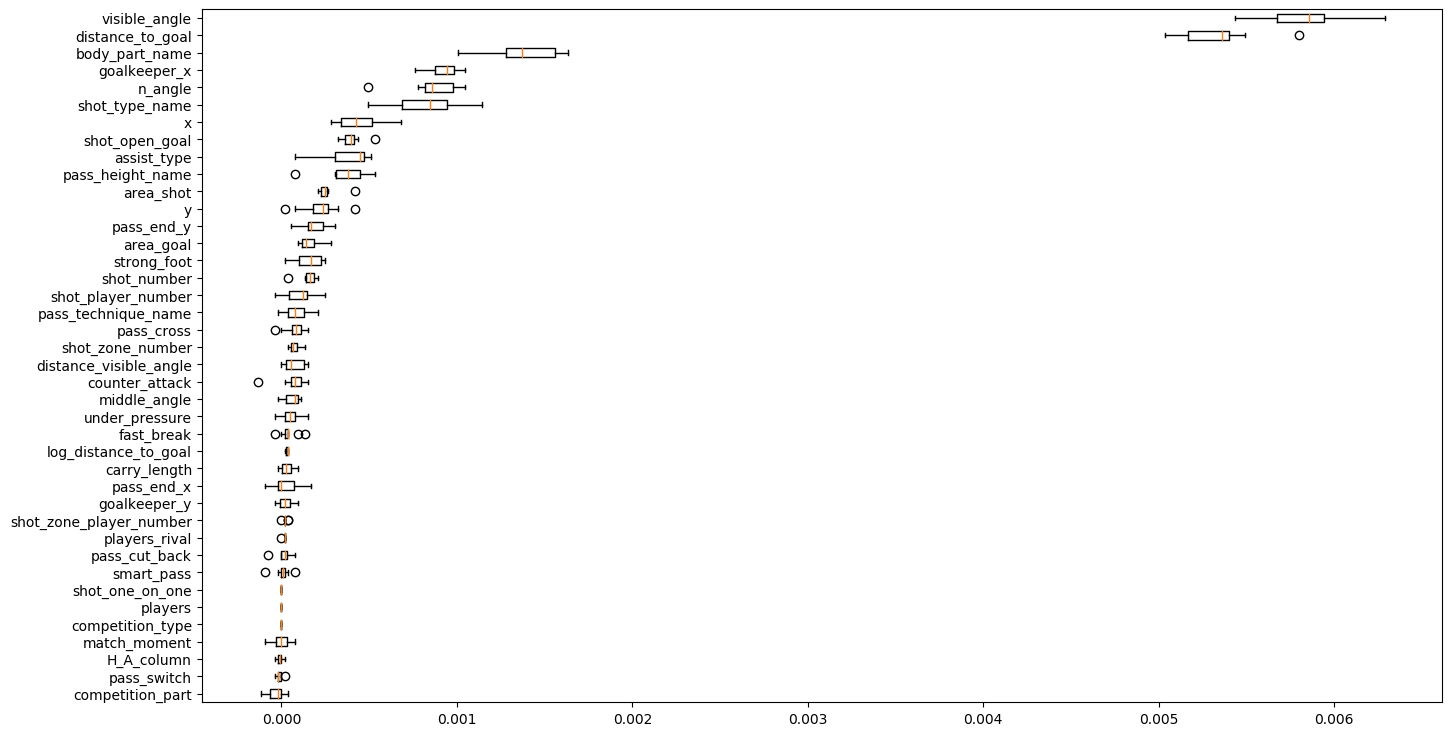

In [68]:
fig, ax = plt.subplots(figsize=(16, 9))
sorted_idx = perm_result.importances_mean.argsort()
bar_plot = ax.boxplot(perm_result.importances[sorted_idx].T, vert=False, labels=X_train.columns[sorted_idx])

Same proces for penalties

In [69]:
searchcv_p = BayesSearchCV(estimator=lgbm,
                         n_iter=100,
                         search_spaces=lgbm_param_grid,
                         cv=5,
                         n_jobs=-1)
searchcv_p.fit(X_penalty_train, y_penalty_train)
y_pred_lgbm_p = searchcv_p.best_estimator_.predict_proba(X_penalty_test)

In [70]:
perm_result_p = permutation_importance(searchcv_p.best_estimator_, X_penalty_train, y_penalty_train, n_repeats=10,
                                       random_state=42)
df_perm_importance_p = pd.DataFrame({'Feature':X_penalty_train.columns,
                                   'importance': perm_result_p.importances.mean(axis=1),
                                   'std_dev': perm_result_p.importances.std(axis=1)})
df_perm_importance_p.sort_values('importance', ascending=False, inplace=True)
df_perm_importance_p.reset_index(drop=True, inplace=True)
df_perm_importance_p

,Feature,importance,std_dev
0,shot_number,0.012500,0.004460
1,match_moment,0.010823,0.003883
2,H_A_column,0.007317,0.002876
3,competition_part,0.007165,0.002463
4,shot_player_number,0.003354,0.003109
5,competition_type,0.000000,0.000000
6,players,0.000000,0.000000
7,players_rival,0.000000,0.000000


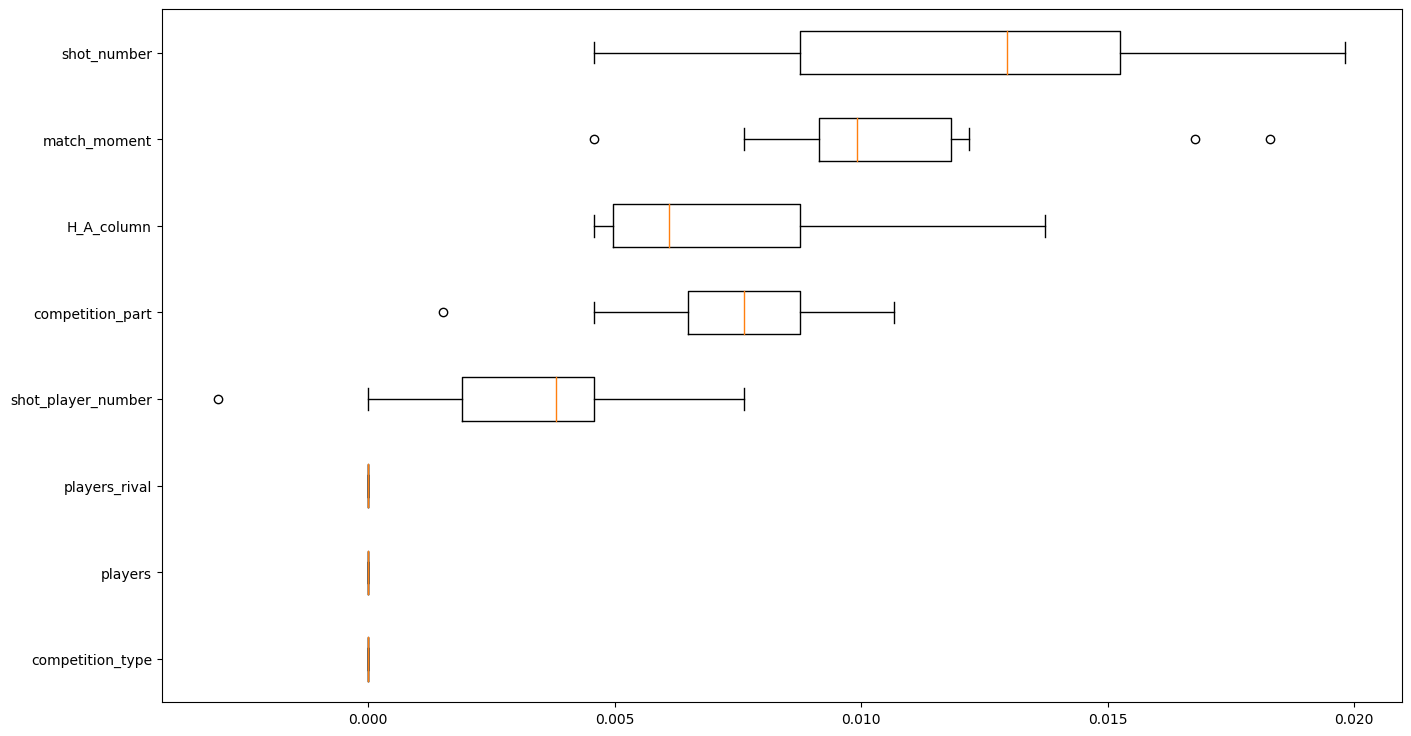

In [71]:
fig, ax = plt.subplots(figsize=(16, 9))
sorted_idx = perm_result_p.importances_mean.argsort()
bar_plot = ax.boxplot(perm_result_p.importances[sorted_idx].T, vert=False, labels=X_penalty_train.columns[sorted_idx])

# Test

In [72]:
# Calculate calibration curve on test data for non-penalty shots
# logistic regression
y_pred_lr = np.concatenate([y_pred_lr_npp, y_pred_lr_npo])
y_true_test_lr = np.concatenate([y_npp_test, y_npo_test])
fraction_of_positives_lr, mean_predicted_value_lr = calibration_curve(y_true_test_lr, y_pred_lr[:,1], n_bins=10)
# LightGBM
fraction_of_positives_lgbm, mean_predicted_value_lgbm = calibration_curve(y_test, y_pred_lgbm[:, 1], n_bins=10)

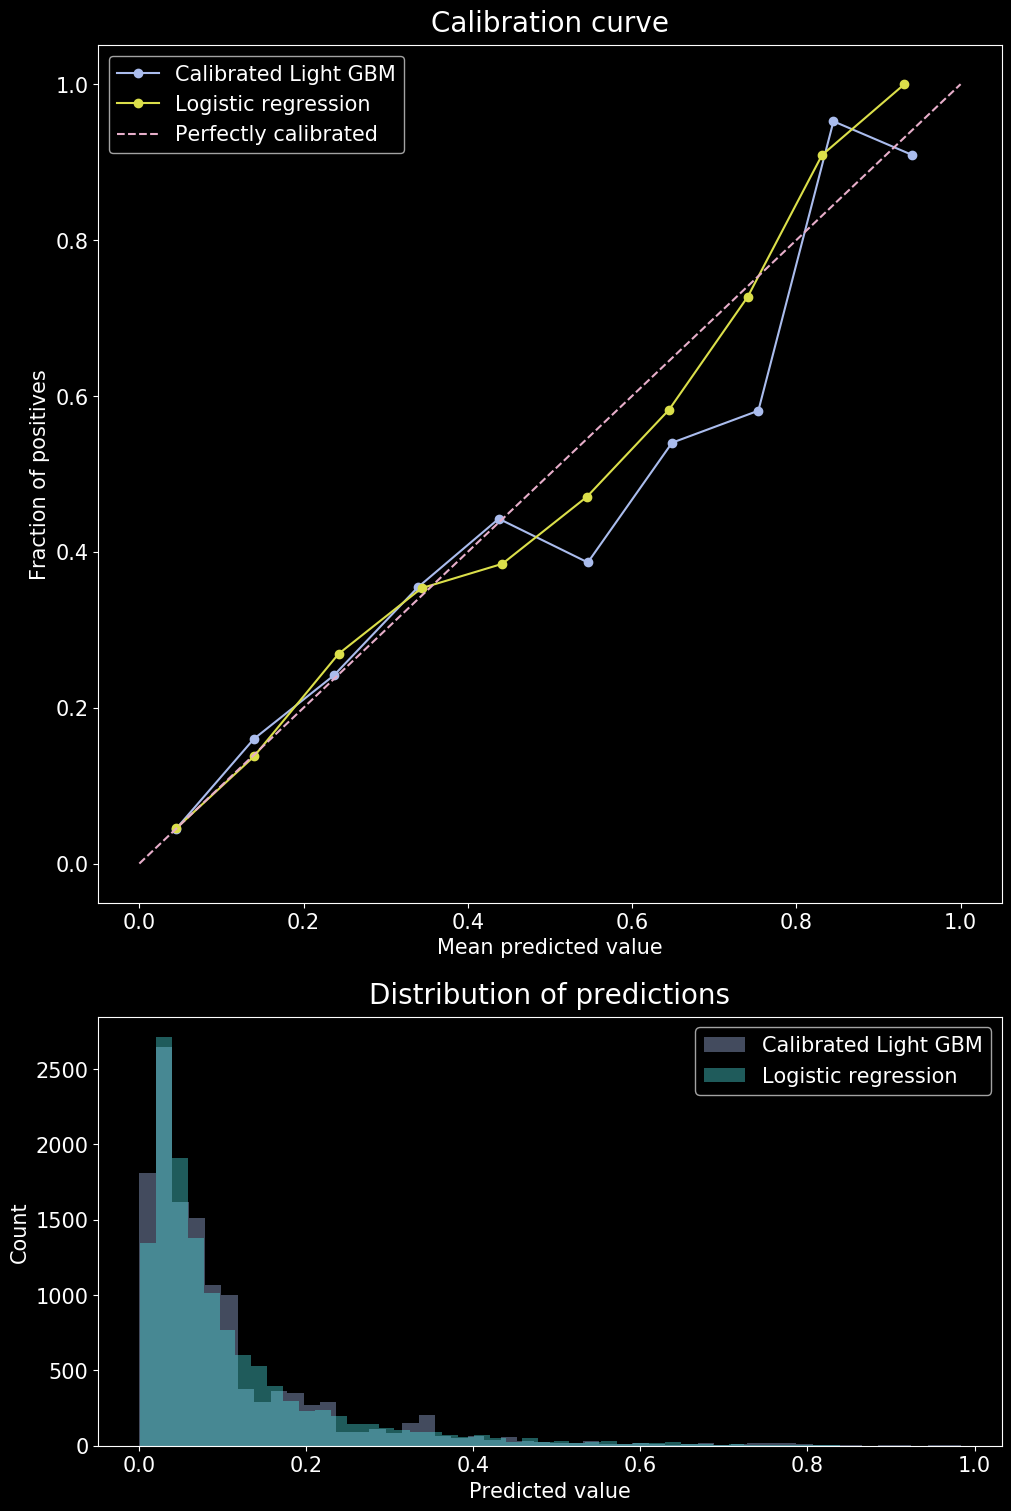

In [74]:
# Plot calibration curve on test data
plt.style.use('dark_background')
fig = plt.figure(constrained_layout=True, figsize=(10, 15))
gs = fig.add_gridspec(ncols=1, nrows=2, height_ratios=(2/3, 1/3))
ax1 = fig.add_subplot(gs[0])
ax1.plot(mean_predicted_value_lgbm, fraction_of_positives_lgbm, "-o", color='#aabced', label='Calibrated Light GBM')
ax1.plot(mean_predicted_value_lr, fraction_of_positives_lr, "-o", color='#dbdf4a', label='Logistic regression')
ax1.plot([0, 1], [0, 1], "--", color='#e7aeca', label="Perfectly calibrated")
ax1.set_xlabel('Mean predicted value', fontsize=15)
ax1.set_ylabel('Fraction of positives', fontsize=15)
ax1.set_title('Calibration curve', fontsize=20, pad=10)
ax1.legend(fontsize=15)
ax1.tick_params(labelsize=15)
ax2 = fig.add_subplot(gs[1])
sns.distplot(y_pred_lgbm[:, 1], color='#aabced', label='Calibrated Light GBM', kde=False, ax=ax2)
sns.distplot(y_pred_lr[:,1], color='#4fe4e4', label='Logistic regression', kde=False, ax=ax2)
ax2.set_xlabel('Predicted value', fontsize=15)
ax2.set_ylabel('Count', fontsize=15)
ax2.tick_params(labelsize=15)
ax2.legend(fontsize=15)
ax2.set_title('Distribution of predictions', fontsize=20, pad=10);
fig.savefig(os.path.join(cwd, 'figures', '22_calibration_curve2.png'), bbox_inches = 'tight', pad_inches = 0.2)

In [75]:
print("The log loss of the non-penalty model with Logistic Regression is: " + str(log_loss(y_true_test_lr, y_pred_lr[:,1])))
print("The ROC AUC score of the non-penalty model with Logistic Regression is: " +str(roc_auc_score(y_true_test_lr,
                                                                                                    y_pred_lr[:,1])))
print('The McFaddens Pseudo R-squared of the non-penalty model with Logistic Regression is:', mcfadden_r2(y_true_test_lr,
                                                                                                    y_pred_lr[:,1]))
print('The Brier score of the non-penalty model with Logistic Regression is:',brier_score_loss(y_true_test_lr, y_pred_lr[:,1],
                                                                                         pos_label=y_true_test_lr.max()))

The log loss of the non-penalty model with Logistic Regression is: 0.2846301821087627
The ROC AUC score of the non-penalty model with Logistic Regression is: 0.7815561430511246
The McFaddens Pseudo R-squared of the non-penalty model with Logistic Regression is: 0.15864339709380737
The Brier score of the non-penalty model with Logistic Regression is: 0.08214078482621053


In [76]:
print("The log loss of the non-penalty model with LightGBM is: " + str(log_loss(y_test, y_pred_lgbm)))
print("The ROC AUC score of the non-penalty model with LightGBM is: " +str(roc_auc_score(y_test, y_pred_lgbm[:,1])))
print('The McFaddens Pseudo R-squared of the non-penalty model with LightGBM is:', mcfadden_r2(y_test, y_pred_lgbm[:,1]))
print('The Brier score of the non-penalty model with LightGBM is:',brier_score_loss(y_test, y_pred_lgbm[:,1],
                                                                                    pos_label=y_test.max()))

The log loss of the non-penalty model with LightGBM is: 0.28110290451095393
The ROC AUC score of the non-penalty model with LightGBM is: 0.7919270246645744
The McFaddens Pseudo R-squared of the non-penalty model with LightGBM is: 0.1690699030785643
The Brier score of the non-penalty model with LightGBM is: 0.08142415230750037


In [77]:
# Calculate calibration curve on test data for penalty shots
# logistic regression
y_true_test_lr_p = y_p_test
fraction_of_positives_lr_p, mean_predicted_value_lr_p = calibration_curve(y_true_test_lr_p, y_pred_lr_p[:,1], n_bins=10)
# lightGBM
fraction_of_positives_lgbm_p, mean_predicted_value_lgbm_p = calibration_curve(y_penalty_test, y_pred_lgbm_p[:, 1],
                                                                              n_bins=10)

Text(0.5, 1.0, 'Distribution of predictions')

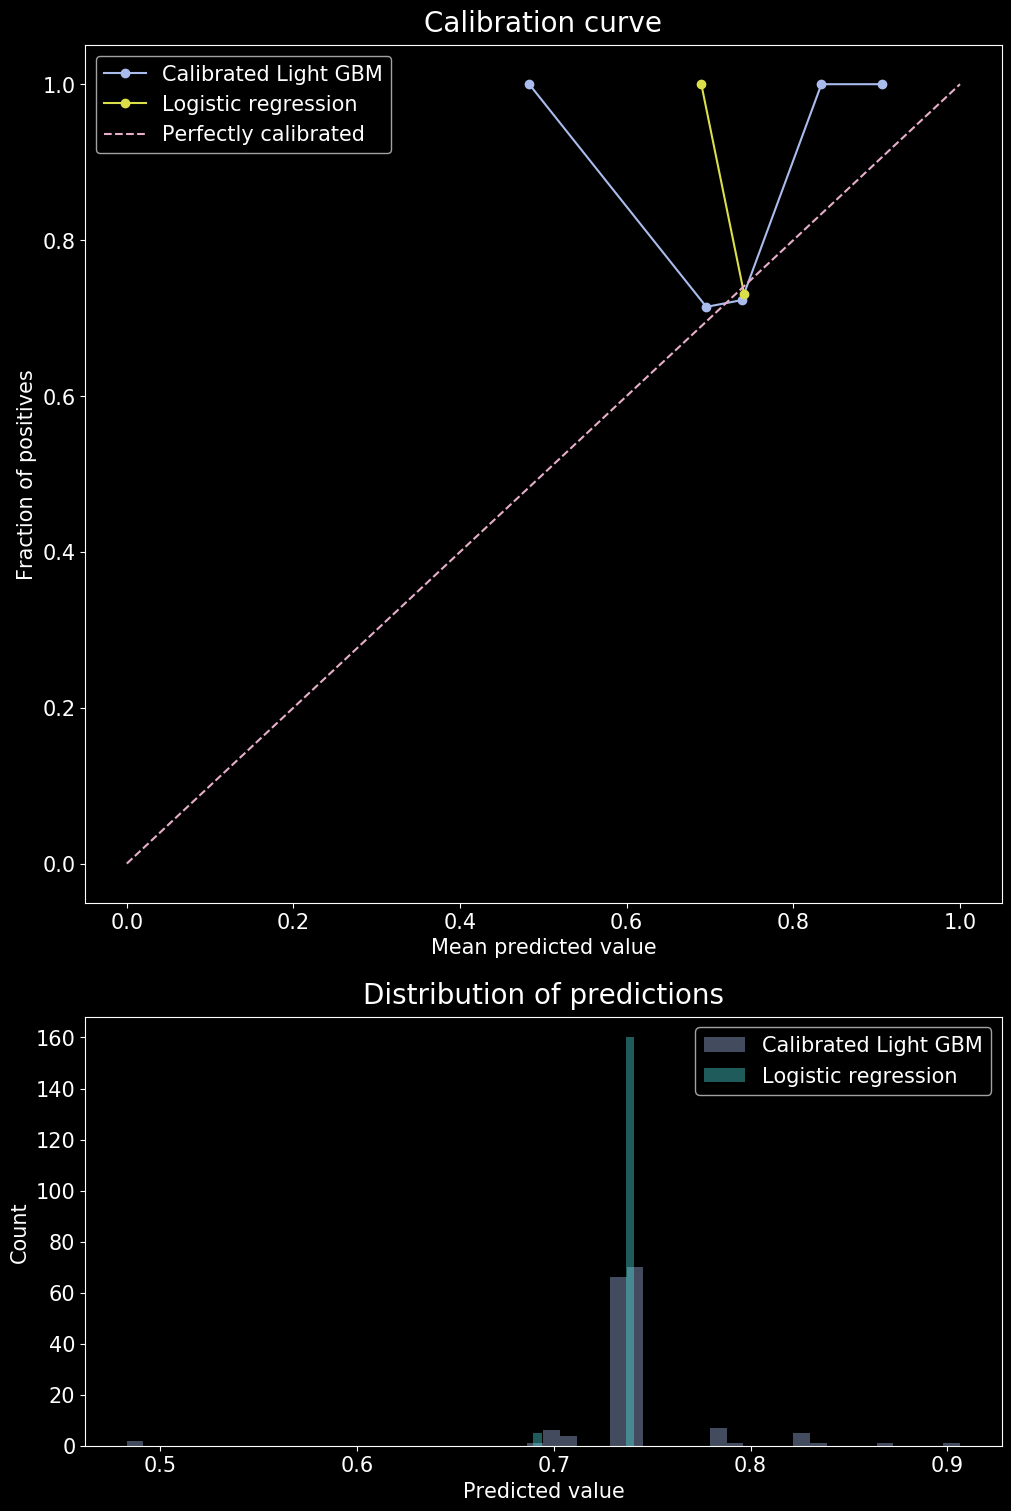

In [78]:
# Plot calibration curve on test data
fig = plt.figure(constrained_layout=True, figsize=(10, 15))
gs = fig.add_gridspec(ncols=1, nrows=2, height_ratios=(2/3, 1/3))
ax1 = fig.add_subplot(gs[0])
ax1.plot(mean_predicted_value_lgbm_p, fraction_of_positives_lgbm_p, "-o", color='#aabced', label='Calibrated Light GBM')
ax1.plot(mean_predicted_value_lr_p, fraction_of_positives_lr_p, "-o", color='#dbdf4a', label='Logistic regression')
ax1.plot([0, 1], [0, 1], "--", color='#e7aeca', label="Perfectly calibrated")
ax1.set_xlabel('Mean predicted value', fontsize=15)
ax1.set_ylabel('Fraction of positives', fontsize=15)
ax1.set_title('Calibration curve', fontsize=20, pad=10)
ax1.legend(fontsize=15)
ax1.tick_params(labelsize=15)
ax2 = fig.add_subplot(gs[1])
sns.distplot(y_pred_lgbm_p[:, 1], color='#aabced', label='Calibrated Light GBM', kde=False, ax=ax2)
sns.distplot(y_pred_lr_p[:,1], color='#4fe4e4', label='Logistic regression', kde=False, ax=ax2)
ax2.set_xlabel('Predicted value', fontsize=15)
ax2.set_ylabel('Count', fontsize=15)
ax2.tick_params(labelsize=15)
ax2.legend(fontsize=15)
ax2.set_title('Distribution of predictions', fontsize=20, pad=10)

In [79]:
print("The log loss of the penalty model with Logistic Regresion is: " + str(log_loss(y_true_test_lr_p, y_pred_lr_p[:,1])))
print("The ROC AUC score of the penalty model with Logistic Regresion is: " +str(roc_auc_score(y_true_test_lr_p,
                                                                                               y_pred_lr_p[:,1])))
print('The McFaddens Pseudo R-squared of the penalty model with Logistic Regresion is:', mcfadden_r2(y_true_test_lr_p,
                                                                                                y_pred_lr_p[:,1]))
print('The Brier score of the penalty model with Logistic Regresion is:',brier_score_loss(y_true_test_lr_p, y_pred_lr_p[:,1],
                                                                         pos_label=y_true_test_lr_p.max()))

The log loss of the penalty model with Logistic Regresion is: 0.5758706160394315
The ROC AUC score of the penalty model with Logistic Regresion is: 0.47950819672131145
The McFaddens Pseudo R-squared of the penalty model with Logistic Regresion is: -0.0038012394860251764
The Brier score of the penalty model with Logistic Regresion is: 0.19357847977312514


In [81]:
print("The log loss of the penalty model with LightGBM is: " + str(log_loss(y_penalty_test, y_pred_lgbm_p)))
print("The ROC AUC score of the penalty model with LightGBM is: " +str(roc_auc_score(y_penalty_test,
                                                                                  y_pred_lgbm_p[:,1])))
print('The McFaddens Pseudo R-squared of the penalty model with LightGBM is:', mcfadden_r2(y_penalty_test,
                                                                                                     y_pred_lgbm_p[:,1]))
print('The Brier score of the penalty model with LightGBM is:',brier_score_loss(y_penalty_test, y_pred_lgbm_p[:,1], 
                                                           pos_label=y_penalty_test.max()))

The log loss of the penalty model with LightGBM is: 0.5699416158898832
The ROC AUC score of the penalty model with LightGBM is: 0.5612847884102173
The McFaddens Pseudo R-squared of the penalty model with LightGBM is: 0.0065336127069226535
The Brier score of the penalty model with LightGBM is: 0.19207247825058882


# Save models

In [82]:
dump(logistic_regression_npp, os.path.join(cwd, 'models', 'lr_pass.joblib'))

['C:\\Users\\sergi77\\Desktop\\UNIR\\TFM\\xG_Model_TFM\\models\\lr_pass.joblib']

In [83]:
dump(logistic_regression_npo, os.path.join(cwd, 'models', 'lr_other.joblib'))

['C:\\Users\\sergi77\\Desktop\\UNIR\\TFM\\xG_Model_TFM\\models\\lr_other.joblib']

In [84]:
dump(logistic_regression_p, os.path.join(cwd, 'models', 'lr_penalty.joblib'))

['C:\\Users\\sergi77\\Desktop\\UNIR\\TFM\\xG_Model_TFM\\models\\lr_penalty.joblib']

In [85]:
dump(searchcv.best_estimator_, os.path.join(cwd, 'models', 'lgbm_model.joblib'))

['C:\\Users\\sergi77\\Desktop\\UNIR\\TFM\\xG_Model_TFM\\models\\lgbm_model.joblib']

In [86]:
dump(searchcv_p.best_estimator_, os.path.join(cwd, 'models', 'lgbm_model_penalty.joblib'))

['C:\\Users\\sergi77\\Desktop\\UNIR\\TFM\\xG_Model_TFM\\models\\lgbm_model_penalty.joblib']

# Save data

In [87]:
# reload shot dataset for ids
df = pd.read_parquet(os.path.join(cwd, 'data', 'shots.parquet'))
df = df[['match_id', 'wyscout_id', 'statsbomb_id']].copy()

In [88]:
x_npo_train3['goal'] = y_npo_train
x_npo_train3['split'] = 'train'
x_npo_test3['goal'] = y_npo_test
x_npo_test3['split'] = 'test'
df_other = pd.concat([x_npo_train3, x_npo_test3])
df_other = df_other.merge(df, left_index=True, right_index=True, validate='1:1', how='left')
df_other.reset_index(drop=True, inplace=True)
df_other.to_parquet(os.path.join(cwd, 'data', 'modelling', 'lr_other2.parquet'))

In [89]:
x_npp_train3['goal'] = y_npp_train
x_npp_train3['split'] = 'train'
x_npp_test3['goal'] = y_npp_test
x_npp_test3['split'] = 'test'
df_pass = pd.concat([x_npp_train3, x_npp_test3])
df_pass = df_pass.merge(df, left_index=True, right_index=True, validate='1:1', how='left')
df_pass.reset_index(drop=True, inplace=True)
df_pass.to_parquet(os.path.join(cwd, 'data', 'modelling', 'lr_pass2.parquet'))

In [90]:
x_p_train3['goal'] = y_p_train
x_p_train3['split'] = 'train'
x_p_test3['goal'] = y_p_test
x_p_test3['split'] = 'test'
df_penalty = pd.concat([x_p_train3, x_p_test3])
df_penalty = df_penalty.merge(df, left_index=True, right_index=True, validate='1:1', how='left')
df_penalty.reset_index(drop=True, inplace=True)
df_penalty.to_parquet(os.path.join(cwd, 'data', 'modelling', 'lr_penalty2.parquet'))

In [91]:
# reload shot dataset for ids
df2 = pd.read_parquet(os.path.join(cwd, 'data', 'shots.parquet'))
mask_penalty = (df2.shot_type_name=='penalty')
df_penalty = df2[mask_penalty].copy()
df_non_penalty = df2[~mask_penalty].copy()
df_penalty = df_penalty[['match_id', 'wyscout_id', 'statsbomb_id']].copy()
df_non_penalty = df_non_penalty[['match_id', 'wyscout_id', 'statsbomb_id']].copy()

In [92]:
X_train['goal'] = y_train
X_train['split'] = 'train'
X_test['goal'] = y_test
X_test['split'] = 'test'
df_lgbm = pd.concat([X_train, X_test])
# exlcude fake shots
df_lgbm = df_lgbm[df_lgbm.index.isin(df_non_penalty.index)].copy()
df_lgbm = df_lgbm.merge(df_non_penalty, how='left', left_index=True, right_index=True, validate='1:1')
df_lgbm.to_parquet(os.path.join(cwd, 'data', 'modelling', 'lgbm.parquet'))



X_penalty_train['goal'] = y_penalty_train
X_penalty_train['split'] = 'train'
X_penalty_test['goal'] = y_penalty_test
X_penalty_test['split'] = 'test'
df_lgbm_penalty = pd.concat([X_penalty_train, X_penalty_test])
# exlcude fake shots
df_lgbm_penalty = df_lgbm_penalty[df_lgbm_penalty.index.isin(df_penalty.index)].copy()
df_lgbm_penalty = df_lgbm_penalty.merge(df_penalty, how='left', left_index=True, right_index=True, validate='1:1')
df_lgbm_penalty.to_parquet(os.path.join(cwd, 'data', 'modelling', 'lgbm_penalty.parquet'))